# Chapter 5. Fine-tuning Large Language Models

## 5.4 Implementation of natural language inference, semantic similarity calculation, and multiple choice question answering models

### 5.4.1 Natural Language Inference

In [1]:
!pip -q install datasets transformers[ja,torch] matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 37.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 25.7 MB/s eta 0:00:00


#### Obtaining Model Prediction Results

In [2]:
from transformers import pipeline

model_name = "llm-book/bert-base-japanese-v3-jnli"
jnli_pipeline = pipeline(model=model_name, device="cuda:0")

config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [3]:
from datasets import load_dataset

valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JNLI", split="validation"
)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [4]:
from tqdm import tqdm

# ClassLabel instance to retrieve label name information
class_label = valid_dataset.features["label"]

results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(valid_dataset)):
    # Obtain the model's prediction results
    model_prediction = jnli_pipeline({"text": example["sentence1"], "text_pair": example["sentence2"]})
    # Convert the true label ID to a label name
    true_label = class_label.int2str(example["label"])

    # Store necessary information for analysis in results
    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction["score"],
            "pred_label": model_prediction["label"],  # The predicted label
            "true_label": true_label,  # The true label
        }
    )

9it [00:00, 13.01it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
2434it [00:45, 53.84it/s]


#### Analyzing Overall Trends

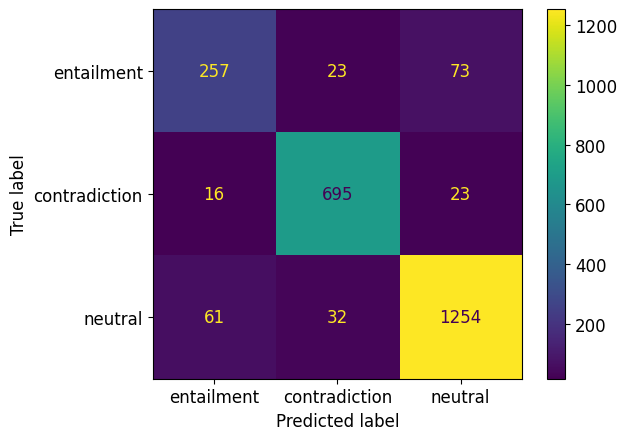

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.rcParams["font.size"] = 12  # Set the font size

# Creating the confusion matrix
confusion_matrix = confusion_matrix(
    y_true=[result["true_label"] for result in results],
    y_pred=[result["pred_label"] for result in results],
    labels=class_label.names,
)
# Display the confusion matrix as an image
ConfusionMatrixDisplay(
    confusion_matrix, display_labels=class_label.names
).plot()

#### Error Analysis

In [6]:
# Collect examples where predictions were incorrect
failed_results = [
    res for res in results if res["pred_label"] != res["true_label"]
]
# Sort by model's prediction probability in descending order
sorted_failed_results = sorted(
    failed_results, key=lambda x: -x["pred_prob"]
)
# Display the top 2 examples with high prediction probability but incorrect predictions
for top_result in sorted_failed_results[:2]:
    sentence1 = valid_dataset[top_result["example_id"]]["sentence1"]  # Premise sentence
    sentence2 = valid_dataset[top_result["example_id"]]["sentence2"]  # Hypothesis sentence

    print(f"前提文 (Premise sentence): {sentence1}")
    print(f"仮説文 (Hypothesis sentence): {sentence2}")
    print(f"予測 (Prediction): {top_result['pred_label']}")
    print(f"正解 (True label): {top_result['true_label']}")
    print(f"予測確率 (Prediction probability): {top_result['pred_prob']:.4f}")
    print("----------------")

前提文 (Premise sentence): おむつをした赤ちゃんが便座の上に立っています。
仮説文 (Hypothesis sentence): オムツをした赤ちゃんが便座の上に立っています。
予測 (Prediction): contradiction
正解 (True label): entailment
予測確率 (Prediction probability): 0.9997
----------------
前提文 (Premise sentence): クマがコンクリートの上に座っています。
仮説文 (Hypothesis sentence): クマが壁にもたれて座っています。
予測 (Prediction): contradiction
正解 (True label): neutral
予測確率 (Prediction probability): 0.9995
----------------
